How many of the 6061 rare diseases tracked by GARD have less than 20 articles?

In [1]:
num_articles = 20 #input("How many abstracts to gather per disease? ")

In [2]:
#Download any necessary datasets & dependencies, only need to do this once
#import sys
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en_core_web_lg
#!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
#!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install requests
#!{sys.executable} -m pip install matplotlib

#Installing dependencies for classify_abs.py
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install nltk
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

import numpy as np
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import spacy
import time
import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt; plt.rcdefaults()

2021-07-05 19:29:36.049366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-05 19:29:36.049391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Read in GARD diseases
df = pd.read_csv('GARD.csv')
df.tail()

,d.gard_id,d.name,d.synonyms
6056,GARD:0013731,T-cell prolymphocytic leukemia,[T Cell Prolymphocytic Leukemia]
6057,GARD:0013735,Spastic paraplegia 47,NaN
6058,GARD:0013737,AP-4-Associated Hereditary Spastic Paraplegia,[Severe intellectual disability and progressiv...
6059,GARD:0013743,"Multicentric osteolysis, nodulosis and arthrop...","[Torg-Winchester Syndrome,Torg Syndrome,Nodulo..."
6060,GARD:0013818,Sphingosine phosphate lyase insufficiency synd...,"[SPL insufficiency syndrome,SPLIS,Familial ste..."


In [4]:
#GARD.csv d.synonyms has oddly saved string data that cannot be converted directly into a list, this converts that
def str2list(string):
    string = str(string).replace('[','')
    string = string.replace(']','')
    string = string.strip()
    str_list = string.split(',')
    for s in str_list:
        s = s.strip()
        if s=='nan':
            str_list.remove('nan')
    return str_list

In [5]:
#Convert d.synonym strings into lists
i=0
for i in range(len(df['d.synonyms'])):
    df['d.synonyms'][i] = str2list(df['d.synonyms'][i])

In [6]:
#Set up a new & easier to use df, with just id and list of names
df_names = pd.DataFrame(df['d.gard_id'],columns=['d.gard_id','d.names'])

rowlist = []
i=0
for i in range(len(df)):
    columnlist=[]
    columnlist.append(df['d.name'][i])
    columnlist+=df['d.synonyms'][i]
    rowlist.append(columnlist)
df_names['d.names'] = rowlist

In [7]:
df_names.tail()

,d.gard_id,d.names
6056,GARD:0013731,"[T-cell prolymphocytic leukemia, T Cell Prolym..."
6057,GARD:0013735,[Spastic paraplegia 47]
6058,GARD:0013737,[AP-4-Associated Hereditary Spastic Paraplegia...
6059,GARD:0013743,"[Multicentric osteolysis, nodulosis and arthro..."
6060,GARD:0013818,[Sphingosine phosphate lyase insufficiency syn...


In [8]:
def get_pmids_abstract(dz_name, maxResults):
    # get results from searching for disease name through EBI API
    term = ''
    dz_words = dz_name.split()
    for word in dz_words:
        term += word + '%20'
    query = term[:-3]
    url = 'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query='+query+'&resulttype=core'
    r = requests.get(url)
    root = ET.fromstring(r.content)

    pmid_abs = {}
    i = 0
    # loop over resulting articles
    for result in root.iter('result'):
        if i >= maxResults:
            break
        pmids = [pmid.text for pmid in result.iter('id')]
        if len(pmids) > 0:
            pmid = pmids[0]
            if pmid[0].isdigit():
                abstracts = [abstract.text for abstract in result.iter('abstractText')]
                if len(abstracts) > 0:
                    pmid_abs[pmid] = abstracts[0]
                    i += 1
    return pmid_abs, i

In [9]:
#Pick all disease names
all_dz_list = df_names['d.names'].values.tolist()

In [10]:
#Actually get all of the Pubmed IDs and Articles
dz_num = {}
dz_pmid_abs = []

t1 = time.time()
counter = 0
for namelist in all_dz_list:
    i = 0
    for name in namelist:
        pmid_abs, abs_returned = get_pmids_abstract(name, num_articles)
        i+=abs_returned
        dz_pmid_abs.append(pmid_abs)
        counter+=1
        if counter%500==0 and counter>0:
            print(counter, time.ctime(time.time()))
        if i>=num_articles:
            break 
    dz_num[namelist[0]] = i
t2 = time.time()
print('It took '+ str(datetime.timedelta(seconds=(t2-t1)))+' to build dataset of '+str(len(all_dz_list)*num_articles)+' abstracts.')
print('Completion time is:',time.ctime(t2))

500 Mon Jul  5 19:38:20 2021
1000 Mon Jul  5 19:46:49 2021
1500 Mon Jul  5 19:55:13 2021
2000 Mon Jul  5 20:03:40 2021
2500 Mon Jul  5 20:12:30 2021
3000 Mon Jul  5 20:21:29 2021
3500 Mon Jul  5 20:30:14 2021
4000 Mon Jul  5 20:39:11 2021
4500 Mon Jul  5 20:48:01 2021
5000 Mon Jul  5 20:56:54 2021
5500 Mon Jul  5 21:05:47 2021
6000 Mon Jul  5 21:14:48 2021
6500 Mon Jul  5 21:23:45 2021
7000 Mon Jul  5 21:32:48 2021
7500 Mon Jul  5 21:42:02 2021
8000 Mon Jul  5 21:51:14 2021
It took 2:26:34.025209 to build dataset of 121220 abstracts.
Completion time is: Mon Jul  5 21:56:11 2021


In [11]:
#Sort the dictionary
dz_num = dict(sorted(dz_num.items(), key=lambda x: x[1]))

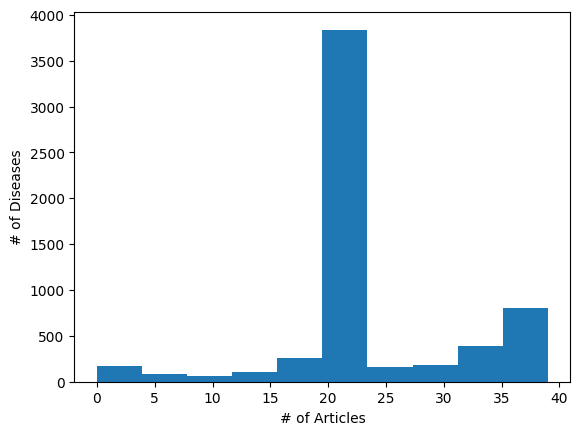

In [12]:
#Plot the figure
objects = tuple(dz_num)
performance = list(dz_num.values())
#y_pos = np.arange(performance)

fig = plt.figure()
plt.ylabel('# of Diseases')
plt.xlabel('# of Articles')
plt.hist(performance)

plt.show()

In [13]:
fig.savefig('All_Disease_Hist20.png', dpi=400, bbox_inches='tight')

In [14]:
df_alldiseases = pd.DataFrame(columns=['disease','pmid', 'abstract'])
i=0
j=0
for namelist in all_dz_list:
    disease = namelist[0]
    for k, v in dz_pmid_abs[j].items():
        pmid = k
        abstract = v
        df_alldiseases.loc[i] = [disease]+[pmid]+[abstract]
        i+=1
    j+=1

In [15]:
df_alldiseases

,disease,pmid,abstract
0,GRACILE syndrome,30226971,"GRACILE Syndrome, is an autosomal recessive di..."
1,GRACILE syndrome,24655110,GRACILE syndrome is a rare autosomal recessive...
2,GRACILE syndrome,33750016,Kenny-Caffey syndrome type 2 (KCS2) and osteoc...
3,GRACILE syndrome,34160123,Retinoic acid exposures as well as defects in ...
4,GRACILE syndrome,34077822,"We draw attention to a unique presentation, se..."
...,...,...,...
98547,Sphingosine phosphate lyase insufficiency synd...,34131653,Systemic sclerosis (SSc) is a connective tissu...
98548,Sphingosine phosphate lyase insufficiency synd...,34155851,<h4>Background</h4>Surgical interventions in p...
98549,Sphingosine phosphate lyase insufficiency synd...,34163540,<h4>Background</h4>Systemic sclerosis (SSc) al...
98550,Sphingosine phosphate lyase insufficiency synd...,34071779,<b>Objective:</b> This nationwide study aimed ...


In [16]:
df_alldiseases.to_csv('all_dz_abstract_set20.csv',index=False)